#Individual Convolution of Ankle, Hip, and Wrist Data for HAR
ind_conv_ankle_hip_wrist.ipynb

This is a an end-to-end Jupyter notebook for our public repository https://github.com/imics-lab/Indiv-CNN-Ankle-Hip-Wrist

It is an exploration of different model topologies to include the three sensors as seperate kernels and is the source code for the paper "Individual Convolution of Ankle, Hip, and Wrist Data for Activities-of-Daily Living Classification" presented at the 18th International Conference on Intelligent Environments IE2022.  Please check online and cite this papper if you use this in your work.  (Sorry, I've published this before the conference and don't yet have the full citation info.)

If you are looking for updated code to load and process datasets https://github.com/imics-lab/load_data_time_series is likely to be updated more frequently and enables more loadable functions.

Some references that will be helpful.
* <a href = https://machinelearningmastery.com/keras-functional-api-deep-learning/> Functional tutorial for Keras by Jason Brownlee</a>

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2021

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:
* The data type for the big y and sub ndarrays should be uint8 to save memory.
* Add name lookup to final counts printout.
* The output of the hold-one-out should optionally feed the box-plot directly.
* If the zip file is not found, run-all-cells should stop (raise exception)

In [127]:
# for development I mount my drive, for better portability here I'm using the
# current directory instead of a full drive mount path.
my_path = '.'

#Imports

In [128]:
import os
import shutil
import time
from datetime import date
import random #to remove random sampling and create validation group

import urllib.request # to get files from web w/o !wget

from scipy import io #for loadmat, matlab conversion
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping
#imports for computing and displaying output metrics
import seaborn as sns
from tabulate import tabulate # for verbose tables, showing data
import pandas as pd
from tensorflow.keras.utils import to_categorical # for one-hot encoding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support


In [129]:
#Helpful functions especially inside colab - originally in load_data_utils
from requests import get
def what_is_my_name():
    """returns the name of the running colab ipynb file"""
    #code is readily available on web - not original
    if 'google.colab' in str(get_ipython()):
        my_name = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    else:
        # seems a bit complicated to get filename in any environment
        # and hard coding the name here will make this not portable
        # this should elminate the failure in non-colab instances though
        my_name = 'Executing local file, not running in CoLab'
    return my_name
def get_env_info():
    """returns the CPU and GPU info, only tested in colab.  Empty GPU indicates
    running in colab instance without GPU acceleration."""
    #cpu_model = !grep 'model name' /proc/cpuinfo
    #env_info = 'CPU1: ' + cpu_model[0] + '\n'
    #env_info += 'CPU2: ' + cpu_model[1] + '\n'
    # the code above uses a magic which runs only in iPython, does not work
    # when imported to other notebooks.  Acknowledgement to 
    # https://janakiev.com/blog/python-shell-commands/ for this alternative
    stream = os.popen('grep "model name" /proc/cpuinfo')
    env_info = stream.read()

    if 'google.colab' in str(get_ipython()):
        #gpu_info = !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
        #env_info += 'GPU: ' + str(gpu_info[1]) + '\n'
        stream2 = os.popen('nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv')
        env_info += 'GPU: ' + stream2.read()
    else:
        env_info += "Not running in colab, GPU info unknown"
    return env_info
def get_log_fname(
    log_file_dir = '/content/drive/My Drive/Colab_Run_Results',
    base_fname = "unnamed"):
    """checks that log_file_dir exists and returns unique full filename
    which is concatenation of dir, base_name, and current UTC time"""
    if (not os.path.isdir(log_file_dir)):
        print("WARNING: " + log_file_dir + " directory does not exist.")
    timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) #UTC time
    log_fname = base_fname +'_'+timestamp + '.txt'
    full_log_fname = os.path.join(log_file_dir, log_fname)
    return full_log_fname
#Helper function since frequently checking and logging shapes
#credit https://stackoverflow.com/users/4944093/george-petrov for name method
#this method has name issues when being called.
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    for i in np_arr_list:
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes
print('My name: ', what_is_my_name())
print('My env_info: \n', get_env_info())
print('A new log_fname: ', get_log_fname(log_file_dir = my_path))

My name:  ind_conv_ankle_hip_wrist.ipynb
My env_info: 
 model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
GPU: name, driver_version, memory.total [MiB]
Tesla P100-PCIE-16GB, 460.32.03, 16280 MiB

A new log_fname:  ./unnamed_Jun-21-2022_2118.txt


#Unzip the local zipfile
You must accept the terms of the dataset and download a copy from this site and place it into your current directory.  Even zipped this dataset is quite large, it will take time to transfer and process.

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/G23QTS#

filename is assumed to be the default 'dataverse_files.zip' in my_path

**Please cite the paper associtated this this dataset** if you use it in your work.

In [130]:
def unzip_leotta(
    orig_zipfile, #full file name of original dataset zipfile
    working_dir = os.path.join(my_path,'dataset') # location of unzipped files
    ):
    """check for local copy, if none unzips the dataset structure in working_dir"""
    if (os.path.isdir(working_dir)):
        print("Using existing archive in ", working_dir)
        return
    else:
        print("Unzipping Leotta 2021 dataset")
        if (os.path.exists(orig_zipfile)):
            print("Using source file", orig_zipfile)
            shutil.unpack_archive(orig_zipfile,working_dir,'zip')
        else:
            print("Error: ", orig_zipfile, " not found, exiting")
            return
unzip_leotta(orig_zipfile = os.path.join(my_path,'dataverse_files.zip'))

Using existing archive in  ./dataset


# The following functions are used to build a Pandas dataframe from the raw datafiles.

In [131]:
def df_from_csv (
    sub_num, # 1 - 8
    sensor_loc, # ankle, hip, wrist
    working_dir = os.path.join(my_path, 'dataset')): # location of unzipped files in colab 
    """reads csv, returns pandas df with accel x/y/z/ttl, label, sub_num"""
    fnameX = sensor_loc + '_X_0' + str(sub_num) +  '.csv'
    fnamey = sensor_loc + '_Y_0' + str(sub_num) +  '.csv'
    ffnameX = os.path.join(working_dir, sensor_loc, fnameX)
    ffnamey = os.path.join(working_dir, sensor_loc, fnamey)
    print ('Processing: ', ffnameX, ffnamey)
    df = pd.read_csv(ffnameX)
    if (sensor_loc == 'wrist'): # Centrepoint device has different header name
        df.rename(columns={'Timestamp UTC': 'Timestamp'}, inplace=True)
    # the imported Timestamp is an object - need to convert to DateTime
    # in order to set the index to DateTime format.  Enables resampling etc.
    # Leaving these here - helpful to debug if leveraging this code!
        #print("*** Start ***")
        #print(type(df.index))
        #print(df.info(verbose=True))  
    df['Timestamp'] = pd.to_datetime(df['Timestamp']) 
    df.set_index('Timestamp', drop = True, inplace = True)
    if (sensor_loc != 'wrist'): # Centrepoint doesn't have non-accel columnns
        df = df.drop(['Temperature','Gyroscope X','Gyroscope Y','Gyroscope Z',
                      'Magnetometer X','Magnetometer Y','Magnetometer Z'], axis=1)
    df_sqd = df.pow(2)[['Accelerometer X','Accelerometer Y','Accelerometer Z']] #square each accel
    df_sum = df_sqd.sum(axis=1) #add sum of squares, new 1 col df
    df.loc[:,'accel_ttl'] = df_sum.pow(0.5)-1  # sqrt and remove 1g due to gravity
    del df_sqd, df_sum
    df.columns = [sensor_loc + '_accel_x', sensor_loc + '_accel_y', sensor_loc + '_accel_z', sensor_loc + '_accel_ttl']
    # add activity numbers - number of rows are the same in this dataset
    # Why doesn't this work? df['label'] = pd.read_csv(ffnamey, dtype='Int64')
    dfy = pd.read_csv(ffnamey)
    df['label']=dfy['label'].to_numpy() # this works, above doesn't?
    df['label'] = df['label'].astype(int) # change from float to int
    del dfy
    # add column with subject number
    df['sub'] = sub_num
    return df

In [132]:
def to_fixed_timedelta(df_in, new_time_step='50ms'):
    """resamples DateTime indexed dataframe to new_time_step.  May
    return NaN per resample method (happens on irregular samples)"""
    #print("Resampling at ",new_time_step,": Original # rows = ",len(df_in.index))
    orig_rows = len(df_in.index)
    df_out = df_in.resample(new_time_step).mean()
    df_out = df_out.interpolate() #linear interpolation for nan
    print("Resampling to", new_time_step, "Original # rows = ",orig_rows,
          "New # rows = ",len(df_out.index))
    return df_out
# method copied from MobiAct_ADL_get_X_y_sub.ipynb, it is named this way
# because it can also be used to "correct" sample jitter in smartphone data

In [133]:
def df_from_one_sub (sub_num): # 1 - 8
    """calls df_from_csv for each of the three csv files - ankle/hip/wrist
    for a single subject, combines, and returns a single dataframe.  wrist
    data is downsampled to 100Hz to match ankle and hip data."""
    my_sub_num = sub_num # not sure necessary but easier to follow...
    df_ankle = df_from_csv(sub_num = my_sub_num, sensor_loc = 'ankle')
    df_hip = df_from_csv(sub_num = my_sub_num, sensor_loc = 'hip')
    #wrist is a bit more complicated since the sample rate is different
    df_wrist = df_from_csv(sub_num = my_sub_num, sensor_loc = 'wrist')
    df_wrist = to_fixed_timedelta(df_wrist,new_time_step='10ms')
    if ((df_ankle['label'].equals(df_hip['label']))
            and (df_ankle['sub'].equals(df_hip['sub']))) :
            # and (df_ankle['label'].equals(df_wrist['label']))
            # and (df_ankle['sub'].equals(df_wrist['sub']))) :
            # I am so confused - these seem to match...workaround for now.
        print('confirmed label and sub match - dropping from ankle and hip')
        df_ankle.drop(['label','sub'], axis=1, inplace=True)
        df_hip.drop(['label','sub'], axis=1, inplace=True)
        df_temp = df_ankle.join(df_hip)
        df_final = df_temp.join(df_wrist)
        del df_temp
        return df_final
    else:
        print('ankle hip label match = ',df_ankle['label'].equals(df_hip['label']))
        print('ankle hip sub match = ',df_ankle['sub'].equals(df_hip['sub']))
        print('ankle wrist label match = ',df_ankle['label'].equals(df_wrist['label']))
        print('ankle wrist sub match = ',df_ankle['sub'].equals(df_wrist['sub']))
        raise Exception('label and sub do not match, cannot combine dataframes')

# A quick check before processing all subject data.

In [134]:
df_temp = df_from_one_sub(1)
display(df_temp)

Processing:  ./dataset/ankle/ankle_X_01.csv ./dataset/ankle/ankle_Y_01.csv
Processing:  ./dataset/hip/hip_X_01.csv ./dataset/hip/hip_Y_01.csv
Processing:  ./dataset/wrist/wrist_X_01.csv ./dataset/wrist/wrist_Y_01.csv
Resampling to 10ms Original # rows =  780800 New # rows =  305000
confirmed label and sub match - dropping from ankle and hip


,ankle_accel_x,ankle_accel_y,ankle_accel_z,ankle_accel_ttl,hip_accel_x,hip_accel_y,hip_accel_z,hip_accel_ttl,wrist_accel_x,wrist_accel_y,wrist_accel_z,wrist_accel_ttl,label,sub
Timestamp,,,,,,,,,,,,,,
2020-07-30 11:21:00.000,-0.035156,-1.027832,0.029785,0.028864,-0.583984,-0.764160,0.374023,0.031926,0.475777,0.029808,0.934387,0.049075,0.0,1.0
2020-07-30 11:21:00.010,-0.022949,-1.023926,0.033203,0.024721,-0.579102,-0.756348,0.374512,0.023563,0.481189,0.013713,0.918378,0.036949,0.0,1.0
2020-07-30 11:21:00.020,-0.010254,-1.028320,0.038574,0.029094,-0.578613,-0.758301,0.367676,0.022252,0.490935,0.032158,0.904531,0.029686,0.0,1.0
2020-07-30 11:21:00.030,-0.000977,-1.026855,0.048340,0.027993,-0.578125,-0.756836,0.374023,0.023192,0.498793,0.031644,0.909606,0.037908,0.0,1.0
2020-07-30 11:21:00.040,0.003906,-1.031250,0.038574,0.031979,-0.575195,-0.755371,0.372559,0.019919,0.514537,0.030619,0.906663,0.042950,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-30 12:11:49.950,-0.050781,-1.023438,0.137695,0.033907,0.170410,-0.591797,0.217285,-0.346949,0.189643,0.628053,0.171765,-0.321824,0.0,1.0
2020-07-30 12:11:49.960,-0.055664,-1.007813,0.147949,0.020135,0.154297,-0.579590,0.225586,-0.359203,0.196538,0.616035,0.173937,-0.330363,0.0,1.0
2020-07-30 12:11:49.970,-0.055664,-1.022461,0.135742,0.032933,0.145996,-0.566406,0.232910,-0.370415,0.197798,0.607956,0.171755,-0.337960,0.0,1.0


# This code splits the dataframe into X, y, sub numpy arrays.

In [135]:
def split_df_to_timeslice_nparrays(df, features, time_steps, step):
    """slice the df into segments of time_steps length and return X, y, sub
    ndarrays.  If step = time_steps there is no overlap of the sliding window.
    Discards any window with mixed or unknown (0 in dataset)labels.
    Updated from original in e4_get_X_y_sub to accept list of features."""
    N_FEATURES = len(features)
    segments = []
    labels = []
    subject = []
    for i in range(0, len(df) - time_steps, step):
        #df_segX = df[['accel_x', 'accel_y', 'accel_z','accel_ttl']].iloc[i: i + time_steps]
        df_segX = df[features].iloc[i: i + time_steps]
        df_lbl = df['label'].iloc[i: i + time_steps]
        df_sub = df['sub'].iloc[i: i + time_steps]
        # Save only if labels are the same for the entire segment and valid
        if (df_lbl.value_counts().iloc[0] != time_steps):
            #print('Segment starting at',i,'contains multiple labels.  Discarding.')
            continue

        if 0 in df_lbl.values :
            #print('Segment starting at',i,'contains Undefined labels.  Discarding')
            continue
        # Save only if sub is the same for the entire segment and valid
        if (df_sub.value_counts().iloc[0] != time_steps):
            #print('Segment starting at',i,'contains multiple subjects.  Discarding.')
            continue
        segments.append(df_segX.to_numpy())
        labels.append(df['label'].iloc[i])
        subject.append(df['sub'].iloc[i])
        #this still requires high memory instance on colab.
        del df_segX
        del df_lbl
        del df_sub
        #gc.collect # attempt are lowering the RAM useage

    # Bring the segments into a better shape, convert to nparrays
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    subject = np.asarray(subject)
    # both labels and sub are row arrays, change to single column arrays
    labels = labels[np.newaxis].T
    subject = subject[np.newaxis].T
    # check for nan - issue with resampled data
    bad_data_locations = np.argwhere(np.isnan(reshaped_segments))
    np.unique(bad_data_locations[:,0]) #[:,0] accesses just 1st column
    if (bad_data_locations.size==0):
        print("No NaN entries found")
    else:
        print("Warning: Output arrays contain NaN entries")
        print("execute print(X[99]) # to view single sample")
    return reshaped_segments, labels, subject

In [136]:
def get_X_y_sub(
    # you probably need to change this path to your google drive mount
    #orig_zipfile = '/content/drive/My Drive/Datasets/ADL_Leotta_2021.zip',
    #working_dir='/content/temp', # this directory will be created inside colab
    time_steps = 300, # number of timesteps per sample 300 @ 100Hz = 3 seconds
    step = 300 #if equal to time_steps there will be no sliding window overlap
    ):
    """processes dataset zip file to extract csv file and convert into X (data),
     y (labels), and sub (subject number) ndarrays.
     Returns X, y, sub, xys_info (a text file)
    """
    #unzip_leotta(orig_zipfile = orig_zipfile, working_dir = working_dir)
    #xys_info = 'not setup for Leotta dataset'
    for i in range(1,9):
        print('Processing subject number', i)
        df_temp = df_from_one_sub (sub_num = i)
        feature_list = list(df_temp.columns)
        feature_list.remove('label')
        feature_list.remove('sub')
        print("Using",len(feature_list),'features',feature_list)
        my_X, my_y, my_sub = split_df_to_timeslice_nparrays(df_temp, feature_list, time_steps, step)
        if i==1:
            X = my_X
            y = my_y
            sub = my_sub
        else:
            X = np.vstack([X, my_X])
            y = np.vstack([y, my_y])
            sub = np.vstack([sub, my_sub])
        #print(get_shapes([X, y, sub]))
    return X, y, sub

# Main function to form Numpy arrays
Requires high-RAM runtime on Colab and runs for a few minutes.

In [137]:
# X, y, sub = get_X_y_sub()
# # Print out attributes of the three big arrays
# print("Final ndarray info - before train/test split")
# headers = ("Initial Array","shape", "object type", "data type")
# mydata = [("X", X.shape, type(X), X.dtype),
#             ("y", y.shape, type(y), y.dtype),
#             ("sub", sub.shape, type(sub), sub.dtype)]
# print(tabulate(mydata, headers=headers))

# Process and save the X, y, sub numpy arrays 
So extraction does need to be repeated when doing "run-all" requires high-RAM runtime on Colab and runs for a few minutes.

In [138]:
xys_info = 'Early output, needs logging updates'
output_dir = my_path
if (os.path.isdir(output_dir)):
    #quick check for existing files, '.ipynb_checkpoints' file 
    #makes it more complicated to see if directory is empty
    if (not os.path.isfile(output_dir + '/X.npy')):
        summary = "Leotta hand/wrist/ankle data\n"
        summary += "Saved to " + output_dir + "\n"
        summary += "Generated by " + what_is_my_name() 
        summary += " on " + time.strftime('%b-%d-%Y_%H%M', time.localtime())

        info_fname = output_dir +'/'+'info.txt'
        full_info = summary + "\n" + xys_info + "\n"
        print(full_info)
        X, y, sub = get_X_y_sub()
        # Print out attributes of the three big arrays
        print("Final ndarray info - before train/test split")
        headers = ("Initial Array","shape", "object type", "data type")
        mydata = [("X", X.shape, type(X), X.dtype),
                    ("y", y.shape, type(y), y.dtype),
                    ("sub", sub.shape, type(sub), sub.dtype)]
        print(tabulate(mydata, headers=headers))

        # save arrays
        with open(info_fname, "w") as file_object:
            file_object.write(full_info)

        if True:
            np.save(output_dir + '/'+'X.npy',X)
            np.save(output_dir + '/'+'y.npy',y)
            np.save(output_dir + '/'+'sub.npy',sub)
    else:
        print("Warning directory "+output_dir+" contains X.npy")
        print("Skipping - Please delete X/y/sub.npy files to rebuild")
else:
    print(output_dir + " not found, please create directory") 

Warning . contains X.npy
skipping. Please delete X/y/sub.npy files to rebuild


In [139]:
def leotta_2021_load_dataset(
    verbose = True,
    use_saved_xysub = False, # get X,y,sub from zip, True = faster to used saved ones
    incl_xyz_accel = False, # include component accel_x/y/z in ____X data
    incl_rms_accel = True, # add rms value (total accel) of accel_x/y/z in ____X data
    incl_val_group = False, # split train into train and validate
    split_subj = dict
                (train_subj = [1,2,3,7],
                validation_subj = [4,8],
                test_subj = [5,6]),
    one_hot_encode = True # make y into multi-column one-hot, one for each activity
    ):
    """calls e4_get_X_y_sub and processes the returned arrays by separating
    into _train, _validate, and _test arrays for X and y based on split_sub
    dictionary."""
    log_info = "Generated by " + what_is_my_name() + "\n"
    today = date.today()
    log_info += today.strftime("%B %d, %Y") + "\n"
    log_info += "sub dict = " + str(split_subj) + "\n"
    if (not use_saved_xysub):
        orig_zipfile = '/content/drive/My Drive/Datasets/ADL_Leotta_2021.zip'
        X, y, sub, xys_info = get_X_y_sub(orig_zipfile=orig_zipfile)
        log_info += 'Processing'+str(orig_zipfile)+"\n"
    else:
        # read previously stored X, y, sub arrays instead of creating from zip
        # saves time when running multiple train/test split experiments
        # e.g. passing different subject dictionaries to this method
        # create & save X, y, sub using Leotta_2021_get_X_y_sub.ipynb interactively
        input_dir = my_path
        X = np.load(input_dir + '/'+'X.npy')
        y = np.load(input_dir + '/'+'y.npy')
        sub = np.load(input_dir + '/'+'sub.npy')
        log_info += "X, y, sub loaded from "+str(input_dir)+"\n"
    # write initial array info to log_info
    headers = ("Initial Array","shape", "object type", "data type")
    mydata = [("X", X.shape, type(X), X.dtype),
              ("y", y.shape, type(y), y.dtype),
              ("sub", sub.shape, type(sub), sub.dtype)]
    if (verbose):
        print(tabulate(mydata, headers=headers))
    log_info += tabulate(mydata, headers=headers) + "\n"
    #remove component accel if needed
    if (not incl_xyz_accel):
        if (verbose):
            print("Removing component accel")
        X = np.delete(X, [0,1,2,4,5,6,8,9,10], 2)
    if (not incl_rms_accel):
        if (verbose):
            print("Removing total accel")
        X = np.delete(X, [3,7,11], 2)  

    if (one_hot_encode):
        # integer encode
        y_vector = np.ravel(y) #encoder won't take column vector
        le = LabelEncoder()
        integer_encoded = le.fit_transform(y_vector) #convert from string to int
        name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        if (verbose):
            print("One-hot-encoding: category names -> int -> one-hot \n")
            print(name_mapping) # seems risky as interim step before one-hot
        log_info += "One Hot:" + str(name_mapping) +"\n\n"
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        #print("One-hot-encoding",onehot_encoder.categories_)
        y=onehot_encoded
        #return X,y
    # split by subject number pass in dictionary
    sub_num = np.ravel(sub[ : , 0] ) # convert shape to (1047,)
    if (not incl_val_group):
        train_index = np.nonzero(np.isin(sub_num, split_subj['train_subj'] + 
                                        split_subj['validation_subj']))
        x_train = X[train_index]
        y_train = y[train_index]
    else:
        train_index = np.nonzero(np.isin(sub_num, split_subj['train_subj']))
        x_train = X[train_index]
        y_train = y[train_index]

        validation_index = np.nonzero(np.isin(sub_num, split_subj['validation_subj']))
        x_validation = X[validation_index]
        y_validation = y[validation_index]

    test_index = np.nonzero(np.isin(sub_num, split_subj['test_subj']))
    x_test = X[test_index]
    y_test = y[test_index]

    headers = ("Returned Array","shape", "object type", "data type")
    mydata = [("x_train:", x_train.shape, type(x_train), x_train.dtype),
                    ("y_train:", y_train.shape ,type(y_train), y_train.dtype)]
    if (incl_val_group):
        mydata += [("x_validation:", x_validation.shape, type(x_validation), x_validation.dtype),
                        ("y_validation:", y_validation.shape ,type(y_validation), y_validation.dtype)]
    mydata += [("x_test:", x_test.shape, type(x_test), x_test.dtype),
                    ("y_test:", y_test.shape ,type(y_test), y_test.dtype)]
    if (verbose):
        print(tabulate(mydata, headers=headers))
    log_info += tabulate(mydata, headers=headers)
    if (incl_val_group):
        return x_train, y_train, x_validation, y_validation, x_test, y_test, log_info
    else:
        return x_train, y_train, x_test, y_test, log_info

In [140]:
xyz = False
rms = True
x_train, y_train, x_test, y_test, load_info = \
leotta_2021_load_dataset(incl_val_group = False, 
                            use_saved_xysub = True,
                            incl_xyz_accel = xyz,
                            incl_rms_accel = rms,
                            verbose = False)
# Note:  OTHER referenced in readme.txt was deleted during the processing,
# and the one-hot encoding shifted everything by one, hence RELAX = 0 now
t_names = ['RELAX','KEYBOARD_WRITING','LAPTOP','HANDWRITING',
            'HANDWASHING','FACEWASHING','TEETHBRUSH','SWEEPING','VACUUMING',
            'EATING','DUSTING','RUBBING','DOWNSTAIRS','WALKING',
            'WALKING_FAST','UPSTAIRS_FAST','UPSTAIRS']
# Print final counts for label ndarray - not quite as easy as pandas df
if (False):
    print("Final Label Counts - Training Set")
    y_train_notOH = np.argmax(y_train, axis=-1) # undo one-hot encoding
    unique, counts = np.unique(y_train_notOH, return_counts=True)
    print (np.asarray((unique, counts)).T)
    print("Final Label Counts - Test Set")
    y_test_notOH = np.argmax(y_test, axis=-1) # undo one-hot encoding
    unique, counts = np.unique(y_test_notOH, return_counts=True)
    print (np.asarray((unique, counts)).T)

# Methods to split the data by sensor location

In [141]:
# yes - this needs refactoring badly...
def split_by_sensor_no_val(x_train, y_train, x_test, y_test, load_info):
    # Column positions depend on component and total accel
    if((xyz == False) and (rms == True)):
        x_train_ankle = x_train[:,:,0:1]
        x_train_hip = x_train[:,:,1:2]
        x_train_wrist = x_train[:,:,2:3]
        x_test_ankle = x_test[:,:,0:1]
        x_test_hip = x_test[:,:,1:2]
        x_test_wrist = x_test[:,:,2:3]
    # Column positions depend on component and total accel
    if((xyz == True) and (rms == False)):
        x_train_ankle = x_train[:,:,0:3]
        x_train_hip = x_train[:,:,3:6]
        x_train_wrist = x_train[:,:,6:9]
        x_test_ankle = x_test[:,:,0:3]
        x_test_hip = x_test[:,:,3:6]
        x_test_wrist = x_test[:,:,6:9]
    if((xyz == True) and (rms == True)):
        x_train_ankle = x_train[:,:,0:4]
        x_train_hip = x_train[:,:,4:8]
        x_train_wrist = x_train[:,:,8:12]
        x_test_ankle = x_test[:,:,0:4]
        x_test_hip = x_test[:,:,4:8]
        x_test_wrist = x_test[:,:,8:12]
    return x_train_ankle,x_test_ankle,x_train_hip,x_test_hip,x_train_wrist,x_test_wrist,load_info

In [142]:
def split_by_sensor(xyz, rms, x_train, y_train, x_validate, y_validate, x_test, y_test, load_info):
    load_info += "Split by sensor:  xyz ="+str(xyz)+"rms ="+str(rms)
    if((xyz == False) and (rms == True)):
        x_train_ankle = x_train[:,:,0:1]
        x_train_hip = x_train[:,:,1:2]
        x_train_wrist = x_train[:,:,2:3]
        x_validate_ankle = x_validate[:,:,0:1]
        x_test_ankle = x_test[:,:,0:1]
        x_validate_hip = x_validate[:,:,1:2]
        x_test_hip = x_test[:,:,1:2]
        x_validate_wrist = x_validate[:,:,2:3]
        x_test_wrist = x_test[:,:,2:3]
    if((xyz == True) and (rms == False)):
        x_train_ankle = x_train[:,:,0:3]
        x_train_hip = x_train[:,:,3:6]
        x_train_wrist = x_train[:,:,6:9]
        x_validate_ankle = x_validate[:,:,0:3]
        x_validate_hip = x_validate[:,:,3:6]
        x_validate_wrist = x_validate[:,:,6:9]
        x_test_ankle = x_test[:,:,0:3]
        x_test_hip = x_test[:,:,3:6]
        x_test_wrist = x_test[:,:,6:9]
    if((xyz == True) and (rms == True)):
        x_train_ankle = x_train[:,:,0:4]
        x_train_hip = x_train[:,:,4:8]
        x_train_wrist = x_train[:,:,8:12]
        x_test_ankle = x_test[:,:,0:4]
        x_test_hip = x_test[:,:,4:8]
        x_test_wrist = x_test[:,:,8:12]
    return x_train_ankle,x_test_ankle,x_validate_ankle,x_validate_hip, x_validate_wrist, x_train_hip,x_test_hip,x_train_wrist,x_test_wrist,load_info

# Functions to build and train a three 1D-CNN functional model
topology and good article
[here](https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf)

In [143]:
# topology and good article here
# https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
# ref for functional model https://keras.io/guides/functional_api/
interactive = False # set to False if only wanting the definitions
k_size = 33
def build_3input_CNN(x_train_ankle, x_train_hip, x_train_wrist, y_train, k_size = k_size):
    n_outputs = y_train.shape[1]
    # input layers - 1st dim is timesteps, 2nd is features
    ankle_input = keras.Input(shape = (x_train_ankle.shape[1], x_train_ankle.shape[2]), name = "ankle")
    hip_input = keras.Input(shape = (x_train_hip.shape[1], x_train_hip.shape[2]), name = "hip")
    wrist_input = keras.Input( shape = (x_train_wrist.shape[1], x_train_wrist.shape[2]), name = "wrist")

    a = layers.Conv1D(filters=100, kernel_size=k_size, activation='relu')(ankle_input)
    a = layers.Conv1D(filters=100, kernel_size=k_size, activation='relu')(a)
    a = layers.Dropout(0.5)(a)
    a = layers.MaxPooling1D(pool_size=24)(a)

    h = layers.Conv1D(filters=100, kernel_size=k_size, activation='relu')(hip_input)
    h = layers.Conv1D(filters=100, kernel_size=k_size, activation='relu')(h)
    h = layers.Dropout(0.5)(h)
    h = layers.MaxPooling1D(pool_size=24)(h)

    w = layers.Conv1D(filters=100, kernel_size=k_size, activation='relu')(wrist_input)
    w = layers.Conv1D(filters=100, kernel_size=k_size, activation='relu')(w)
    w = layers.Dropout(0.5)(w)
    w = layers.MaxPooling1D(pool_size=24)(w)

    merged = layers.Concatenate()([a, h, w])
    merged = layers.GlobalAveragePooling1D()(merged)
    pred = layers.Dense(n_outputs, activation='softmax', name='act_pred')(merged)

    model = keras.Model(
        inputs=[ankle_input, hip_input, wrist_input],
        outputs=[pred],
    )
    return model

In [144]:
def train_3input_CNN(model, x_train_ankle, x_train_hip, x_train_wrist,
                                  x_validate_ankle,x_validate_hip, x_validate_wrist,y_validate,
    BATCH_SIZE = 32,    # Typical values are 8, 16 or 32
    NUM_EPOCHS = 100): # Max number run unless earlystopping callback fires
    # see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    NUM_EPOCHS = 100
    callback = EarlyStopping(monitor='val_loss', mode = 'min', patience=10)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    history = model.fit(
        {"ankle": x_train_ankle, "hip": x_train_hip, "wrist": x_train_wrist},
        {"act_pred": y_train},
        #batch_size = BATCH_SIZE,
        epochs=NUM_EPOCHS,
        callbacks=[callback],
        validation_data=({"ankle": x_validate_ankle, "hip": x_validate_hip, "wrist": x_validate_wrist},y_validate),
        verbose = 1) #0 = silent, 1 = progress bar, 2 = one line per epoch
    return history, model
def train_3input_CNN_no_val(model,x_train_ankle, x_train_hip, x_train_wrist,y_train,
    BATCH_SIZE = 32,    # Typical values are 8, 16 or 32
    NUM_EPOCHS = 100): # Max number run unless earlystopping callback fires
    # see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    NUM_EPOCHS = 100
    callback = EarlyStopping(monitor='loss', mode = 'min', patience=8)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    history = model.fit(
        {"ankle": x_train_ankle, "hip": x_train_hip, "wrist": x_train_wrist},
        {"act_pred": y_train},
        #batch_size = BATCH_SIZE,
        epochs=NUM_EPOCHS,
        callbacks=[callback],
        verbose = 0) #0 = silent, 1 = progress bar, 2 = one line per epoch
    return history, model
if (interactive):
#if (True):
    history, model = train_3input_CNN(model, x_train_ankle, x_train_hip, x_train_wrist,y_train,NUM_EPOCHS = 100)
    #show final training loss
    print(dataset, "3 x 1D CNN Functional Model")
    #print("Final Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
    plt.plot(history.history["loss"], label="Training Loss")
    #plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.ylim([0,2.5]) #set limit - 1.2 has been a good value experimentally
    plt.legend()
    plt.show()


In [145]:
def run_3input_CNN(model,x_test):
    predictions = model.predict(x_test, verbose = 0, batch_size = 32)
    #must use values not one-hot encoding, use argmax to convert
    y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
    return y_pred

if (interactive):
    y_pred = run_3input_CNN(model, {"ankle": x_test_ankle, "hip": x_test_hip, "wrist": x_test_wrist})
    y_test_act = np.argmax(y_test, axis=-1) # undo one-hot encoding
    acc = accuracy_score(y_test_act, y_pred)
    print(classification_report(y_test_act, y_pred, target_names=t_names))
    cm = confusion_matrix(y_test_act, y_pred)
    cm_df = pd.DataFrame(cm,
                        index = t_names, 
                        columns = t_names)
    fig = plt.figure(figsize=(13,10))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
    plt.title('1D CNN Sequential using '+dataset+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout() # keeps labels from being cutoff when saving as pdf
    plt.show()

Initial Array    shape            object type              data type
---------------  ---------------  -----------------------  -----------
X                (4745, 300, 12)  <class 'numpy.ndarray'>  float32
y                (4745, 1)        <class 'numpy.ndarray'>  float64
sub              (4745, 1)        <class 'numpy.ndarray'>  float64
Removing component accel
One-hot-encoding: category names -> int -> one-hot 

{1.0: 0, 2.0: 1, 3.0: 2, 4.0: 3, 5.0: 4, 6.0: 5, 7.0: 6, 8.0: 7, 9.0: 8, 10.0: 9, 11.0: 10, 12.0: 11, 13.0: 12, 14.0: 13, 15.0: 14, 16.0: 15, 17.0: 16}
Returned Array    shape           object type              data type
----------------  --------------  -----------------------  -----------
x_train:          (2373, 300, 3)  <class 'numpy.ndarray'>  float32
y_train:          (2373, 17)      <class 'numpy.ndarray'>  float64
x_validation:     (1181, 300, 3)  <class 'numpy.ndarray'>  float32
y_validation:     (1181, 17)      <class 'numpy.ndarray'>  float64
x_test:           (11

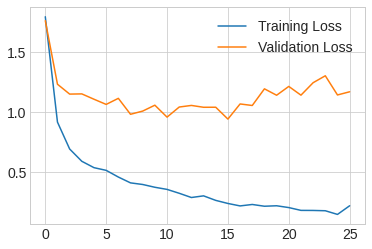

                  precision    recall  f1-score   support

           RELAX       0.83      0.13      0.22        78
KEYBOARD_WRITING       0.57      0.56      0.57        80
          LAPTOP       0.32      0.60      0.41        78
     HANDWRITING       0.82      0.97      0.89        79
     HANDWASHING       0.65      0.62      0.63        78
     FACEWASHING       0.59      0.42      0.49        78
      TEETHBRUSH       0.39      0.45      0.42        78
        SWEEPING       0.71      0.46      0.56        78
       VACUUMING       0.58      0.78      0.67        79
          EATING       0.89      0.95      0.92        79
         DUSTING       0.86      0.76      0.81        79
         RUBBING       0.87      0.86      0.87        79
      DOWNSTAIRS       1.00      1.00      1.00        47
         WALKING       0.97      0.97      0.97        76
    WALKING_FAST       0.97      0.99      0.98        72
   UPSTAIRS_FAST       1.00      1.00      1.00        19
        UPSTA

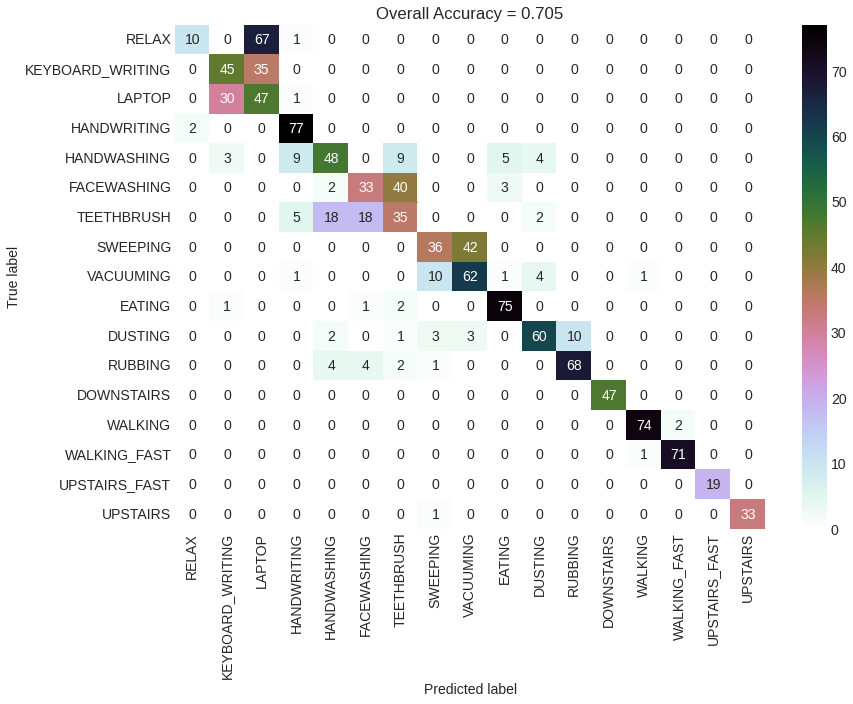

In [146]:
xyz = False;  # do not include component acceleration
rms = True;   # do include magnitude of acceleration vector, rms is misnomer.

x_train, y_train, x_validate, y_validate, x_test, y_test, load_info = \
    leotta_2021_load_dataset(incl_val_group = True, use_saved_xysub = True,incl_xyz_accel = xyz,incl_rms_accel = rms)
print(load_info)
#split by sensor location
x_train_ankle,x_test_ankle,x_validate_ankle,x_validate_hip, x_validate_wrist, x_train_hip,x_test_hip,x_train_wrist,x_test_wrist,load_info =\
     split_by_sensor(xyz, rms, x_train, y_train, x_validate, y_validate, x_test, y_test, load_info)

model = build_3input_CNN(x_train_ankle, x_train_hip, x_train_wrist, y_train)
model.summary()
history, model = train_3input_CNN(model, x_train_ankle, x_train_hip, x_train_wrist,
                                  x_validate_ankle,x_validate_hip, x_validate_wrist,y_validate)
print("Individual Ankle, Hip, Wrist Functional Model")
print("Final Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
#plt.ylim([0,1.2]) #for consistency - 1.2 has been a good value experimentally
plt.legend()
plt.show()
y_pred = run_3input_CNN(model, x_test = {"ankle": x_test_ankle, "hip": x_test_hip, "wrist": x_test_wrist})
y_test_act = np.argmax(y_test, axis=-1) # undo one-hot encoding
acc = accuracy_score(y_test_act, y_pred)
#print (acc)
if (True):
    print(classification_report(y_test_act, y_pred, target_names=t_names))
    #TODO add percentages https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
    cm = confusion_matrix(y_test_act, y_pred)
    cm_df = pd.DataFrame(cm,
                        index = t_names, 
                        columns = t_names)
    fig = plt.figure(figsize=(13,10))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
    plt.title('Overall Accuracy = {0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout() # keeps labels from being cutoff when saving as pdf
    plt.show()
save_log = False
if save_log:
    log_ffname = get_log_fname(
    log_file_dir = '/content/drive/My Drive/Colab_Run_Results',
    base_fname = "Leotta_")
    print("Saving results to", log_ffname)
    with open(log_ffname, "a") as file_object:
        file_object.write(load_info)
        file_object.write("Three x 1D CNN Functional Model")
        file_object.write("Final Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
        file_object.write("Classification Report on Test Set\n")
        file_object.write(classification_report(y_test_act, y_pred, target_names=t_names))
    cm_ffname = log_ffname.split('.')[0] + '_cm.pdf'
    print("saving cm plot as",cm_ffname)
    fig.savefig(cm_ffname,format='pdf')
    full_model_fname = log_ffname.split('.')[0] + '_model.txt'
    with open(full_model_fname, "a") as file_object:
        model.summary(print_fn=lambda x: file_object.write(x + '\n'))
        #acknowledgement https://stackoverflow.com/users/14951382/sparklingdew
    #plot using keras function
    #ref https://keras.io/api/utils/model_plotting_utils/
    full_mplot_fname = log_ffname.split('.')[0] + '_model.png'
    keras.utils.plot_model(model, to_file=full_mplot_fname, show_shapes=True)

# Run experiment: X passes with hold-one-subject-out
WARNING:  This takes awhile to execute - approximately 4 hours on a GPU accelerated Colab instance and generates output only after each subject has been evaluated.   You can skip this execution and see a representative graph using stored data in the last cell.

In [147]:
#this function pulls out num_subj_test subjects and will iterate through
#based on pass_num entered.
#useage:  if num_subj_test is 1 it will perform hold-one-subject out
#if more than one, it will hold-two-subjects-out etc.
def split_sub(
    all_sub = [2,4,6,8,10,12,14,16,18,20], 
    num_hold_out = 2,
    num_to_validation = 2,
    verbose = False,
    ):
    full_list = []
    test_sub_list = [all_sub[i * num_hold_out:(i + 1) * num_hold_out] for i in range((len(all_sub) + num_hold_out - 1) // num_hold_out )]
    for tsub_grp in test_sub_list:
        train_sub = [x for x in all_sub if x not in tsub_grp]
        validation_sub = random.choices(train_sub, k=num_to_validation)
        train_sub = [x for x in train_sub if x not in validation_sub]
        if (verbose):
            print("Result of new_split")
            print("     Train Subjects",train_sub)
            print("Validation Subjects",validation_sub)
            print(".     Test Subjects",tsub_grp)
        test_keys = ["train_subj", "validation_subj","test_subj"] 
        test_values = [train_sub,validation_sub,tsub_grp]
        new_split = dict(zip(test_keys, test_values))
        full_list.append(new_split)
    return full_list

In [148]:
print("Running hold-one-out for each of eight subjects component accel - kernel size =", k_size)
all_my_sub = list(range(1,9)) # range goes to last number -1
my_list = split_sub(all_sub = all_my_sub, num_to_validation = 0, num_hold_out = 1)
sub_num = 0
print("Code has been inserted to skip this due to long execution time")
if(False): #change to True to run
    for sub_dict in my_list:
        #print (sub_dict)
        sub_num += 1
        x_train, y_train, x_test, y_test, load_info = \
        leotta_2021_load_dataset(incl_val_group = False, 
                                use_saved_xysub = True,
                                incl_xyz_accel = False,
                                incl_rms_accel = True,
                                verbose = False,
                                split_subj = sub_dict)
        #split by sensor location
        x_train_ankle,x_test_ankle,x_train_hip,x_test_hip,x_train_wrist,x_test_wrist,load_info \
        = split_by_sensor_no_val(x_train, y_train, x_test, y_test, load_info)
        #print(load_info)
        for pass_num in range(10):
            model = build_3input_CNN(x_train_ankle, x_train_hip, x_train_wrist, y_train, k_size)
            history, model = train_3input_CNN_no_val(model, x_train_ankle, x_train_hip, x_train_wrist, y_train, NUM_EPOCHS = 100)
            y_pred = run_3input_CNN(model, x_test = {"ankle": x_test_ankle, "hip": x_test_hip, "wrist": x_test_wrist})
            y_test_act = np.argmax(y_test, axis=-1) # undo one-hot encoding
            acc = accuracy_score(y_test_act, y_pred)
            if (pass_num == 0):
                output = 'S'+str(sub_num)+' = [{0:.3f}'.format(acc)
            else:
                output = output + ','+ '{0:.3f}'.format(acc)
            if (False):
                print(classification_report(y_test_act, y_pred, target_names=t_names))
                cm = confusion_matrix(y_test_act, y_pred)
                cm_df = pd.DataFrame(cm,
                                    index = t_names, 
                                    columns = t_names)
                fig = plt.figure(figsize=(13,10))
                sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
                plt.title('1D CNN Sequential using '+dataset+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
                plt.ylabel('True label')
                plt.xlabel('Predicted label')
                plt.tight_layout() # keeps labels from being cutoff when saving as pdf
                plt.show()
        print(output+']')

Running hold-one-out for each of eight subjects component accel - kernel size = 33
Code has been inserted to skip this due to long execution time


Fig 7 100Hz, xyz accel, kernel_size = 33
Best Model using GlobalAveragePooling1D
1 0.688
2 0.712
3 0.771
4 0.742
5 0.646
6 0.780
7 0.674
8 0.652
Overall accuracy 0.708


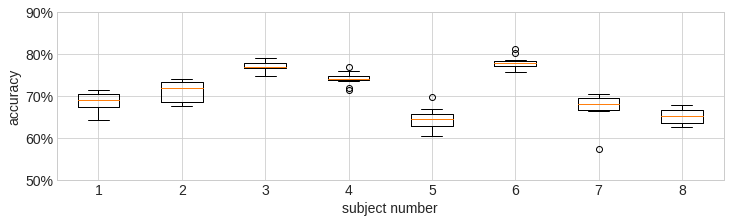

In [149]:
# This data was used in a separate notebook based on stored values
# could be integrated with previous cell with output changes (lists vs text)
fig_num = 7
if(fig_num == 7):
    print('Fig',fig_num,'100Hz, xyz accel, kernel_size = 33') 
    print('Best Model using GlobalAveragePooling1D')
    S1 = [0.714,0.709,0.681,0.691,0.673,0.696,0.709,0.643,0.671,0.691]
    S2 = [0.696,0.736,0.728,0.724,0.682,0.738,0.741,0.677,0.714,0.681]
    S3 = [0.771,0.780,0.750,0.770,0.749,0.789,0.768,0.777,0.791,0.766]
    S4 = [0.742,0.749,0.737,0.744,0.759,0.769,0.739,0.742,0.715,0.720]
    S5 = [0.630,0.637,0.620,0.655,0.670,0.658,0.653,0.698,0.631,0.605]
    S6 = [0.781,0.785,0.803,0.773,0.771,0.763,0.781,0.776,0.758,0.811]
    S7 = [0.575,0.667,0.688,0.665,0.706,0.705,0.698,0.667,0.675,0.693]
    S8 = [0.629,0.680,0.657,0.648,0.635,0.643,0.670,0.672,0.657,0.626]
if(fig_num == 99):
    print('Fig',fig_num,'undescribed')
    S1 = []
    S2 = []
    S3 = []
    S4 = []
    S5 = []
    S6 = []
    S7 = []
    S8 = []

data = [S1,S2,S3,S4,S5,S6,S7,S8]
# calculate mean for each subject and total
sub_num = 0
cumm_avg = 0
cumm_len = 0
for i in data:
    sub_num += 1
    print(sub_num,'{0:.3f}'.format(sum(i)/len(i)))
    cumm_avg += sum(i)
    cumm_len += len(i)
print('Overall accuracy {0:.3f}'.format(cumm_avg/cumm_len))
plt.style.use('seaborn-whitegrid') # Set the aesthetic style of the plots
fig = plt.figure(figsize =(10, 3)) 
  
# Create axes instance 
ax = fig.add_subplot(1, 1, 1)
  
# Create plot 
bp = ax.boxplot(data)

plt.tight_layout()
plt.rcParams.update({'font.size': 14}) 

plt.xlabel("subject number")
plt.ylabel("accuracy")
# Show plot 

ax.set_yticks([0.5,0.6,0.7,0.8,0.9])
ax.set_yticklabels(['50%','60%', '70%', '80%', '90%',''])

# fig_ffname = 'leotta_hold-one-subject-out'+str(fig_num)+'.pdf'
# print('saving',fig_ffname)
# fig.savefig(fig_ffname, bbox_inches="tight") # tight prevents label cut-off
plt.show()